In [ ]:
%load_ext autoreload
%autoreload 2

from autoscript_sdb_microscope_client.structures import AdornedImage
import liftout
import os

import matplotlib.pyplot as plt
import numpy as np
from liftout import utils
from liftout.fibsem import acquire, milling, movement
from liftout.fibsem import utils as fibsem_utils
from liftout.fibsem.acquire import BeamType, ImageSettings, GammaSettings
import scipy.ndimage as ndi
protocol_file = os.path.join(os.path.dirname(liftout.__file__), "protocol_liftout.yml")
print(protocol_file)
settings = utils.load_config(protocol_file)
microscope = fibsem_utils.initialise_fibsem(ip_address=settings["system"]["ip_address"])
image_settings = ImageSettings(
    resolution = settings["imaging"]["resolution"],
    dwell_time = settings["imaging"]["dwell_time"],
    hfw = settings["imaging"]["horizontal_field_width"],
    autocontrast = True,
    beam_type = BeamType.ION,
    gamma = GammaSettings(
        enabled = settings["gamma"]["correction"],
        min_gamma = settings["gamma"]["min_gamma"],
        max_gamma = settings["gamma"]["max_gamma"],
        scale_factor= settings["gamma"]["scale_factor"],
        threshold = settings["gamma"]["threshold"]
    ),
    save = False,
    label = "test",
    save_path=""
)



In [ ]:
import glob
from pprint import pprint

folder = "iter1"
filenames = glob.glob(f"may26/{folder}/*.tif")
pprint(filenames)

In [ ]:

folder = "iter2"
filenames = [  
    f'may26/{folder}/polish_lamella_tilt_-0.02_stage_1_ib.tif',
    # f'may26/{folder}/polish_lamella_tilt_-0.02_stage_2_ib.tif',
    # f'may26/{folder}/polish_lamella_tilt_-0.02_stage_3_ib.tif',
    # f'may26/{folder}/polish_lamella_tilt_-0.02_aligned_ib.tif',
    f'may26/{folder}/polish_lamella_tilt_0.02_stage_1_ib.tif',
    # f'may26/{folder}/polish_lamella_tilt_0.02_stage_2_ib.tif',
    # f'may26/{folder}/polish_lamella_tilt_0.02_stage_3_ib.tif',
    # f'may26/{folder}/polish_lamella_tilt_0.02_aligned_ib.tif'
    ]

ref_fname = f'may26/{folder}\\polish_lamella_crosscorrelation_ref_ib.tif'
img2_fname = filenames[0]

# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 10))

for i, fname in enumerate([ref_fname, img2_fname]):
    print(i, fname)
    adorned_img = AdornedImage.load(fname)
    
    img = ndi.median_filter(adorned_img.data, size=3)
    ax[i].imshow(img.data, cmap="gray")
    ax[i].set_title(fname.split("\\")[-1])
    
plt.show()





In [155]:
from liftout.fibsem.calibration import shift_from_crosscorrelation

ref_img = AdornedImage.load(ref_fname)
tilted_images = [fname for fname in filenames if "ref" not in fname]

def cross_correlate_and_plot(ref_img, img2_fname, lp=50, hp=4, sigma=5):
    
    img2 = AdornedImage.load(img2_fname)
    pixel_size = ref_img.metadata.binary_result.pixel_size.x
    
    dx, dy, xcorr = shift_from_crosscorrelation(ref_img, img2, lowpass=lp, highpass=hp, sigma=sigma, use_rect_mask=True)
    dx_p, dy_p =  int(dx // pixel_size), int(dy // pixel_size)     
    
    # centre px
    cy, cx = ref_img.data.shape[0]//2-1, ref_img.data.shape[1]//2-1 

    # vertical mix of images
    mix = np.zeros_like(ref_img.data)
    mix[cy:, :] = ref_img.data[cy:, :]
    mix[:cy, :] = img2.data[:cy, :]
    
    # shift image
    shift = np.roll(ref_img.data, (dy_p, dx_p), axis=(0, 1))

    # shifted lamella position
    cx_s, cy_s = cx + dx_p, cy + dy_p
    
    # top (f1)
    cy = cy - 30
    cx = cx + 40

    # bottom (f2)
    # cy = cy + 40
    # cx = cx + 40

    sz=500
    ref_crop = ref_img.data[cy-sz:cy+sz, cx-sz:cx+sz]
    img2_crop = img2.data[cy-sz:cy+sz, cx-sz:cx+sz]
    xcorr_crop = xcorr[cy-sz:cy+sz, cx-sz:cx+sz]

    # shift image
    shift = np.roll(img2_crop, (-dy_p, -dx_p), axis=(0, 1))

    # shifted lamella position
    small_cx, small_cy = ref_crop.shape[0]//2-1, ref_crop.shape[1]//2-1 
    small_cx_s, small_cy_s = small_cx + dx_p, small_cy + dy_p
    cx_s, cy_s = cx + dx_p, cy + dy_p


    fig, ax = plt.subplots(1, 4, sharey=True, figsize=(20, 20))
    ax[0].imshow(ndi.median_filter(ref_crop, size=3), cmap="gray")
    ax[0].plot(small_cx, small_cy, "w+", ms=20, label="feature")
    ax[0].set_title("ref_image")
    ax[1].imshow(ndi.median_filter(img2_crop, size=3), cmap="gray")
    ax[1].set_title("titled")
    ax[1].plot(small_cx, small_cy, "w+", ms=20, label="feature")
    ax[2].imshow(ndi.median_filter(shift, size=3), cmap="gray")
    ax[2].plot(small_cx, small_cy, "w+", ms=20, label="feature")

    ax[2].plot(small_cx_s, small_cy_s, "r+", ms=20, label="preshift")
    # ax[2].plot([cx, cx_s], [cy, cy_s], "w--")
    ax[2].set_title("shifted_image")
    ax[3].imshow(xcorr_crop)
    ax[3].set_title("crosscorrelation")


    # ax[0].imshow(ndi.median_filter(ref_img.data, size=3), cmap="gray")
    # ax[0].plot(cx, cy, "w+", ms=20)
    # ax[0].set_title("ref_image")
    # ax[1].imshow(ndi.median_filter(img2.data, size=3), cmap="gray")
    # ax[1].set_title("titled")
    # ax[1].plot(cx, cy, "w+", ms=20)

    # # ax[2].imshow(ndi.median_filter(mix, size=3), cmap="gray")
    # # ax[2].set_title("mixed")
    # ax[2].imshow(ndi.median_filter(shift, size=3), cmap="gray")
    # ax[2].plot(cx, cy, "w+", ms=20)
    # ax[2].plot(cx_s, cy_s, "r+", ms=20)
    # ax[2].plot([cx, cx_s], [cy, cy_s], "w--")
    # ax[2].set_title("shifted_image")
    # ax[3].imshow(xcorr)# np.abs(ref_img.data - shift))
    # ax[3].set_title("crosscorrelation")
    
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    #####
    print("-"*50)
    print(f"file: {img2_fname}")
    print(f"lp: {lp}, hp: {hp}, sigma: {sigma}")
    print(f"dx: {dx:.2e}, dy: {dy:.2e}")
    print(f"dx_p: {dx_p}, dy_p: {dy_p}")
    print("")




------------------------------------ iter1 ------------------------------------ 


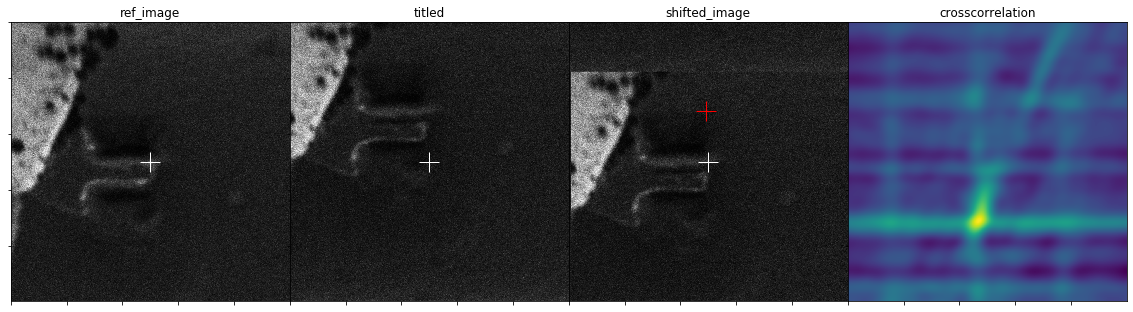

--------------------------------------------------
file: may26/iter1/polish_lamella_tilt_-0.02_stage_1_ib.tif
lp: 50, hp: 10, sigma: 5
dx: -1.14e-07, dy: -2.95e-06
dx_p: -7, dy_p: -181

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
------------------------------------ iter2 ------------------------------------ 


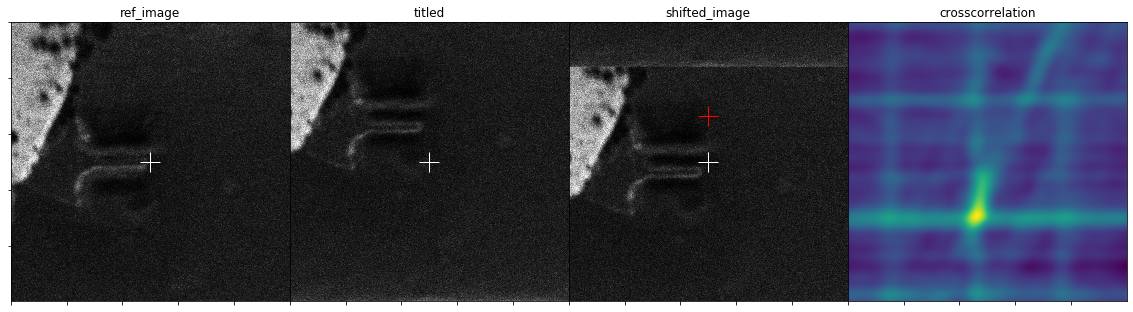

--------------------------------------------------
file: may26/iter2/polish_lamella_tilt_-0.02_stage_1_ib.tif
lp: 50, hp: 10, sigma: 5
dx: -1.63e-08, dy: -2.65e-06
dx_p: -1, dy_p: -163

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
------------------------------------ iter3 ------------------------------------ 


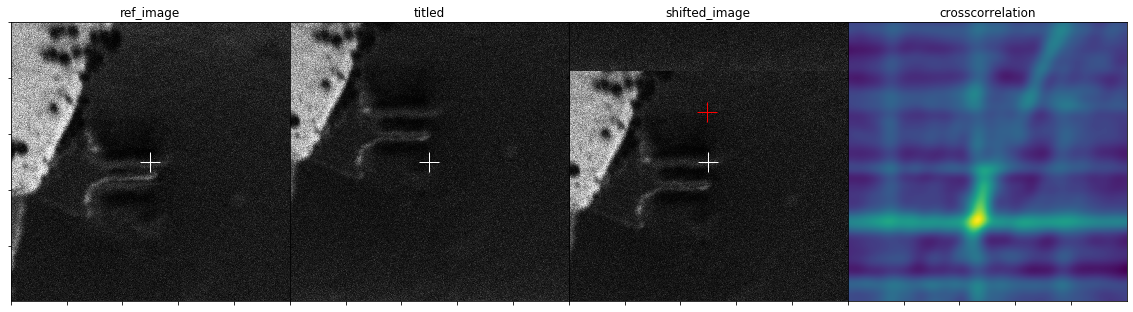

--------------------------------------------------
file: may26/iter3/polish_lamella_tilt_-0.02_stage_1_ib.tif
lp: 50, hp: 10, sigma: 5
dx: -4.88e-08, dy: -2.90e-06
dx_p: -3, dy_p: -179

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
------------------------------------ iter4 ------------------------------------ 


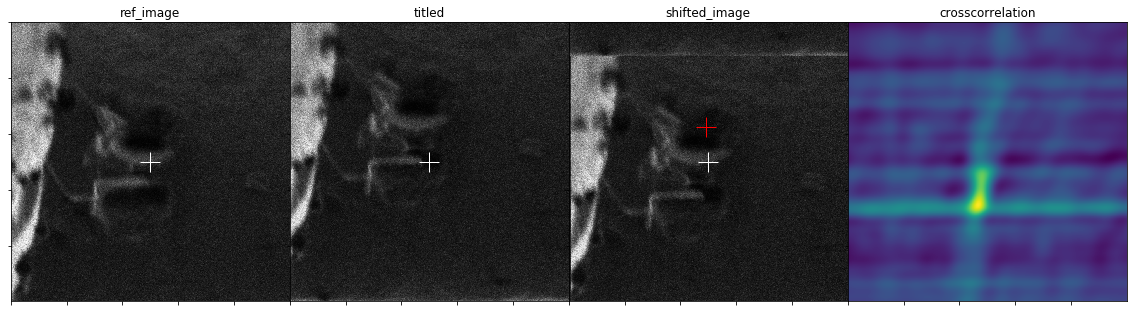

--------------------------------------------------
file: may26/iter4/polish_lamella_tilt_-0.02_stage_1_ib.tif
lp: 50, hp: 10, sigma: 5
dx: -8.14e-08, dy: -2.02e-06
dx_p: -6, dy_p: -124

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
------------------------------------ iter5 ------------------------------------ 


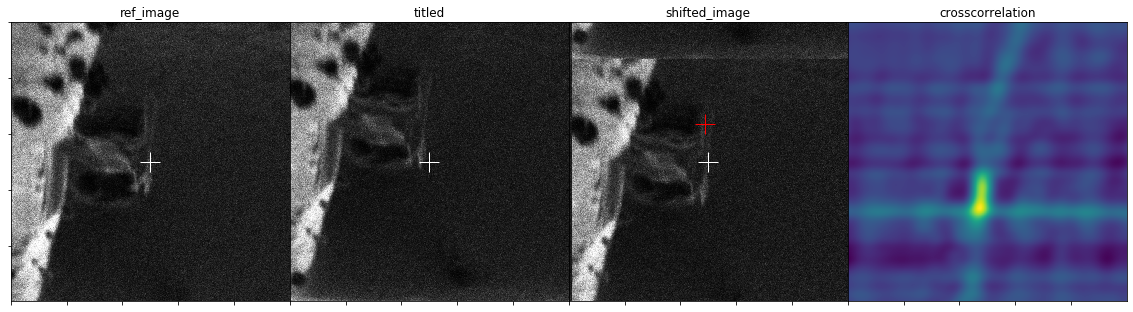

--------------------------------------------------
file: may26/iter5/polish_lamella_tilt_-0.02_stage_1_ib.tif
lp: 50, hp: 10, sigma: 5
dx: -1.79e-07, dy: -2.18e-06
dx_p: -11, dy_p: -134

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [157]:
# run crosscorrelation sweep


folders =  ["iter1", "iter2", "iter3", "iter4", "iter5"]
for folder in folders:

    filenames = [  
        f'may26/{folder}/polish_lamella_tilt_-0.02_stage_1_ib.tif',
        # f'may26/{folder}/polish_lamella_tilt_-0.02_stage_2_ib.tif',
        # f'may26/{folder}/polish_lamella_tilt_-0.02_stage_3_ib.tif',
        # f'may26/{folder}/polish_lamella_tilt_-0.02_aligned_ib.tif',
        f'may26/{folder}/polish_lamella_tilt_0.02_stage_1_ib.tif',
        # f'may26/{folder}/polish_lamella_tilt_0.02_stage_2_ib.tif',
        # f'may26/{folder}/polish_lamella_tilt_0.02_stage_3_ib.tif',
        # f'may26/{folder}/polish_lamella_tilt_0.02_aligned_ib.tif'
        ]

    ref_fname = f'may26/{folder}\\polish_lamella_crosscorrelation_ref_ib.tif'
    ref_img = AdornedImage.load(ref_fname)

    print(f"------------------------------------ {folder} ------------------------------------ ")
    for img2_fname in filenames[:1]:
        for lp in [50]:
            for hp in [10]:
                cross_correlate_and_plot(ref_img, img2_fname, lp=lp, hp=hp, sigma=5)
        print("-"*100)
    print("-"*100)

# white = centre feature
# red = centre feature after shift
# we align ref to titled
# if cc is working, red should end up in on the same feature as white

file: may26/iter1/polish_lamella_tilt_-0.02_stage_1_ib.tif


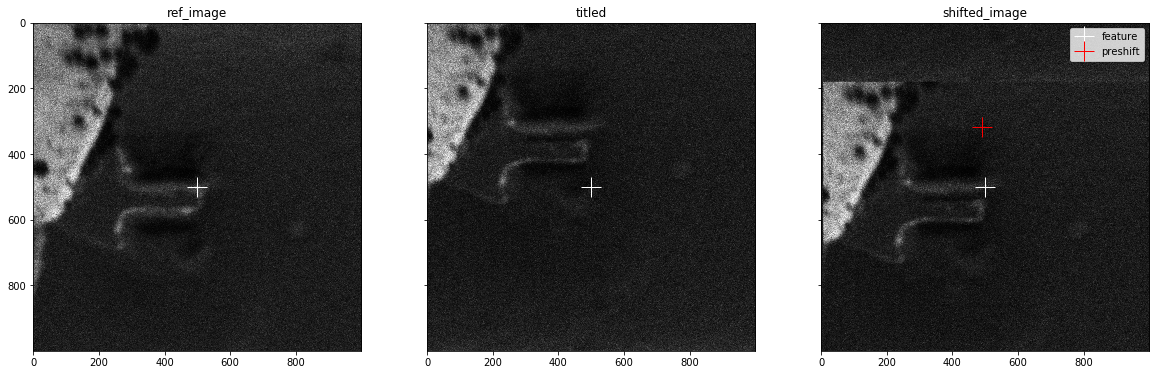

In [154]:
# best: lp = 50, hp = 10, sigma = 5
folder = "iter1"
ref_fname = f'may26/{folder}\\polish_lamella_crosscorrelation_ref_ib.tif'
ref_img = AdornedImage.load(ref_fname)
img2_fname = f'may26/{folder}/polish_lamella_tilt_-0.02_stage_1_ib.tif'
img2 = AdornedImage.load(img2_fname)

# f1 (-0.02)
dx_p = -7
dy_p = -181

# f2 (0.02)
# dx_p = -4
# dy_p = 134


# centre px
cy, cx = ref_img.data.shape[0]//2-1, ref_img.data.shape[1]//2-1 

# top (f1)
cy = cy - 30
cx = cx + 40

# bottom (f2)
# cy = cy + 40
# cx = cx + 40

sz=500
ref_crop = ref_img.data[cy-sz:cy+sz, cx-sz:cx+sz]
img2_crop = img2.data[cy-sz:cy+sz, cx-sz:cx+sz]

# shift image
shift = np.roll(img2_crop, (-dy_p, -dx_p), axis=(0, 1))

# shifted lamella position
small_cx, small_cy = ref_crop.shape[0]//2-1, ref_crop.shape[1]//2-1 
small_cx_s, small_cy_s = small_cx + dx_p, small_cy + dy_p
cx_s, cy_s = cx + dx_p, cy + dy_p

print(f"file: {img2_fname}")
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 20))
ax[0].imshow(ndi.median_filter(ref_crop, size=3), cmap="gray")
ax[0].plot(small_cx, small_cy, "w+", ms=20, label="feature")
ax[0].set_title("ref_image")
ax[1].imshow(ndi.median_filter(img2_crop, size=3), cmap="gray")
ax[1].set_title("titled")
ax[1].plot(small_cx, small_cy, "w+", ms=20, label="feature")
ax[2].imshow(ndi.median_filter(shift, size=3), cmap="gray")
ax[2].plot(small_cx, small_cy, "w+", ms=20, label="feature")

ax[2].plot(small_cx_s, small_cy_s, "r+", ms=20, label="preshift")
# ax[2].plot([cx, cx_s], [cy, cy_s], "w--")
ax[2].set_title("shifted_image")


plt.legend(loc="best")
plt.show()